**Problem statement**: To build a CNN based model which can accurately detect melanoma. Melanoma is a type of cancer that can be deadly if not detected early. It accounts for 75% of skin cancer deaths. A solution which can evaluate images and alert the dermatologists about the presence of melanoma has the potential to reduce a lot of manual effort needed in diagnosis.

The dataset consists of 2357 images of malignant and benign oncological diseases, which were formed from the International Skin Imaging Collaboration (ISIC). All images were sorted according to the classification taken with ISIC, and all subsets were divided into the same number of images, with the exception of melanomas and moles, whose images are slightly dominant.

The data set contains the following diseases:

1.   Actinic keratosis
2.   Basal cell carcinoma
3.   Dermatofibroma
4.   Melanoma
5.   Nevus
6.   Pigmented benign keratosis
7.   Seborrheic keratosis
8.   Squamous cell carcinoma
9.   Vascular lesion


### Importing Skin Cancer Data

### Importing all the important libraries

In [1]:
import pathlib
import tensorflow as tf
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import os
import PIL
from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.keras.models import Sequential

from keras.layers import Dense, Dropout, Activation, Flatten, BatchNormalization, Conv2D, MaxPooling2D, MaxPool2D


In [2]:
## mount the google drive
from google.colab import drive
drive.mount('/content/gdrive')

Mounted at /content/gdrive


This assignment uses a dataset of about 2357 images of skin cancer types. The dataset contains 9 sub-directories in each train and test subdirectories. The 9 sub-directories contains the images of 9 skin cancer types respectively.

In [8]:
# Defining the root path for train and test images 
root_path = '/content/gdrive/My Drive/Melanoma Detection-CNN'

In [10]:
# Defining the path for train and test images
data_dir_train = pathlib.Path(root_path + '/Train')
data_dir_test = pathlib.Path(root_path  + '/Test')

In [11]:
image_count_train = len(list(data_dir_train.glob('*/*.jpg')))
print(image_count_train)
image_count_test = len(list(data_dir_test.glob('*/*.jpg')))
print(image_count_test)

2239
118


### Load using keras.preprocessing

Let's load these images off disk using the helpful image_dataset_from_directory utility.

### Create a dataset

Define some parameters for the loader:

In [12]:
batch_size = 32
img_height = 180
img_width = 180

Use 80% of the images for training, and 20% for validation.

In [13]:
## Write your train dataset here
## Note use seed=123 while creating your dataset using tf.keras.preprocessing.image_dataset_from_directory
## Note, make sure your resize your images to the size img_height*img_width, while writting the dataset
train_ds = tf.keras.preprocessing.image_dataset_from_directory(
    data_dir_train,
    validation_split = 0.2,
    subset = "training",
    seed = 123,
    image_size = (img_height, img_width),
    batch_size = batch_size
  )

Found 2239 files belonging to 9 classes.
Using 1792 files for training.


In [14]:
## Write your validation dataset here
## Note use seed=123 while creating your dataset using tf.keras.preprocessing.image_dataset_from_directory
## Note, make sure your resize your images to the size img_height*img_width, while writting the dataset
val_ds = tf.keras.preprocessing.image_dataset_from_directory(
    data_dir_train,
    validation_split = 0.2,
    subset = "validation",
    seed = 123,
    image_size = (img_height, img_width),
    batch_size = batch_size
  )

Found 2239 files belonging to 9 classes.
Using 447 files for validation.


In [15]:
# List out all the classes of skin cancer and store them in a list. 
# You can find the class names in the class_names attribute on these datasets. 
# These correspond to the directory names in alphabetical order.
class_names = train_ds.class_names
print(class_names)

['actinic keratosis', 'basal cell carcinoma', 'dermatofibroma', 'melanoma', 'nevus', 'pigmented benign keratosis', 'seborrheic keratosis', 'squamous cell carcinoma', 'vascular lesion']


### Visualize the data
#### Visualize one instance of all the nine classes present in the dataset

In [16]:
import matplotlib.pyplot as plt

plt.figure(figsize=(10, 10))
for images, labels in train_ds.take(1):
  for i in range(9):
    ax = plt.subplot(3, 3, i + 1)
    plt.imshow(images[i].numpy().astype("uint8"))
    ax.set_title(class_names[labels[i]])
plt.show()


The `image_batch` is a tensor of the shape `(32, 180, 180, 3)`. This is a batch of 32 images of shape `180x180x3` (the last dimension refers to color channels RGB). The `label_batch` is a tensor of the shape `(32,)`, these are corresponding labels to the 32 images.

`Dataset.cache()` keeps the images in memory after they're loaded off disk during the first epoch.

`Dataset.prefetch()` overlaps data preprocessing and model execution while training.

In [17]:
AUTOTUNE = tf.data.experimental.AUTOTUNE
train_ds = train_ds.cache().shuffle(1000).prefetch(buffer_size=AUTOTUNE)
val_ds = val_ds.cache().prefetch(buffer_size=AUTOTUNE)

### Create the model
#### Todo: Create a CNN model, which can accurately detect 9 classes present in the dataset. Use ```layers.experimental.preprocessing.Rescaling``` to normalize pixel values between (0,1). The RGB channel values are in the `[0, 255]` range. This is not ideal for a neural network. Here, it is good to standardize values to be in the `[0, 1]`

In [18]:
### we should rescale the image
preprocessing_layers = [
    tf.keras.layers.experimental.preprocessing.Rescaling(1./255, input_shape=(180, 180, 3))
]

input_shape = (180,180,3)
num_classes = 9

model = Sequential()
model.add(tf.keras.layers.experimental.preprocessing.Rescaling(1./255, input_shape = input_shape))
model.add(Conv2D(32, kernel_size=(3, 3), activation='relu', padding='same', input_shape = input_shape))
model.add(Conv2D(32, kernel_size=(3, 3), activation='relu', padding='same'))
model.add(MaxPooling2D(pool_size=(2, 2)))

model.add(Conv2D(64, kernel_size=(3, 3), activation='relu', padding='same'))
model.add(MaxPooling2D(pool_size=(2, 2)))

model.add(Conv2D(128, kernel_size=(3, 3), activation='relu', padding='same'))
model.add(MaxPooling2D(pool_size=(2, 2)))

model.add(Flatten())
model.add(Dense(512, activation='relu')) 
model.add(Dropout(0.5))
model.add(Dense(num_classes, activation='softmax'))

### Compile the model
Choose an appropirate optimiser and loss function for model training 

In [19]:
### Todo, choose an appropirate optimiser and loss function
model.compile(optimizer='adam',
              loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
              metrics=['accuracy'])

In [20]:
# View the summary of all layers
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 rescaling_1 (Rescaling)     (None, 180, 180, 3)       0         
                                                                 
 conv2d (Conv2D)             (None, 180, 180, 32)      896       
                                                                 
 conv2d_1 (Conv2D)           (None, 180, 180, 32)      9248      
                                                                 
 max_pooling2d (MaxPooling2D  (None, 90, 90, 32)       0         
 )                                                               
                                                                 
 conv2d_2 (Conv2D)           (None, 90, 90, 64)        18496     
                                                                 
 max_pooling2d_1 (MaxPooling  (None, 45, 45, 64)       0         
 2D)                                                    

### Train the model

In [21]:
epochs = 20
history = model.fit(
  train_ds,
  validation_data=val_ds,
  epochs=epochs
)

Epoch 1/20


/usr/local/lib/python3.7/dist-packages/tensorflow/python/util/dispatch.py:1082: UserWarning: "`sparse_categorical_crossentropy` received `from_logits=True`, but the `output` argument was produced by a sigmoid or softmax activation and thus does not represent logits. Was this intended?"
  return dispatch_target(*args, **kwargs)


56/56 [==============================] - 613s 3s/step - loss: 2.1185 - accuracy: 0.1959 - val_loss: 1.9230 - val_accuracy: 0.2975
Epoch 2/20
56/56 [==============================] - 4s 73ms/step - loss: 1.8787 - accuracy: 0.2969 - val_loss: 1.8897 - val_accuracy: 0.2819
Epoch 3/20
56/56 [==============================] - 4s 72ms/step - loss: 1.8203 - accuracy: 0.3398 - val_loss: 1.6973 - val_accuracy: 0.3736
Epoch 4/20
56/56 [==============================] - 4s 72ms/step - loss: 1.6624 - accuracy: 0.4062 - val_loss: 1.6095 - val_accuracy: 0.4228
Epoch 5/20
56/56 [==============================] - 4s 72ms/step - loss: 1.6171 - accuracy: 0.4180 - val_loss: 1.5307 - val_accuracy: 0.4698
Epoch 6/20
56/56 [==============================] - 4s 72ms/step - loss: 1.5763 - accuracy: 0.4431 - val_loss: 1.5412 - val_accuracy: 0.4832
Epoch 7/20
56/56 [==============================] - 4s 76ms/step - loss: 1.4595 - accuracy: 0.4827 - val_loss: 1.4542 - val_accuracy: 0.4855
Epoch 8/20
56/56 [======

In [22]:
loss, accuracy = model.evaluate(train_ds, verbose=1,)
loss_v, accuracy_v = model.evaluate(val_ds, verbose=1)

print("Accuracy: ", accuracy)
print("Validation Accuracy: ",accuracy_v)
print("Loss: ",loss)
print("Validation Loss", loss_v)


14/14 [==============================] - 0s 26ms/step - loss: 2.3680 - accuracy: 0.4676
Accuracy:  0.8258928656578064
Validation Accuracy:  0.4675615131855011
Loss:  0.5033289790153503
Validation Loss 2.368041753768921


### Visualizing training results

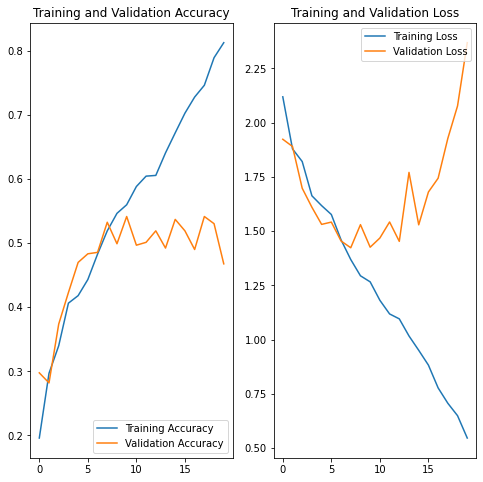

In [23]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

loss = history.history['loss']
val_loss = history.history['val_loss']

epochs_range = range(epochs)

plt.figure(figsize=(8, 8))
plt.subplot(1, 2, 1)
plt.plot(epochs_range, acc, label='Training Accuracy')
plt.plot(epochs_range, val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(1, 2, 2)
plt.plot(epochs_range, loss, label='Training Loss')
plt.plot(epochs_range, val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.show()

### Findings from the Model-1 here:
1. **Overfitted Model**:As we can see, training accuracy is 82.58% while the validation accuracy is just 46.75% which is a clear case of model being overfitted. 
2. Training loss continuously decreases with Epocs however for validation data the loss decreases but starts to increase after 7-8 Epocs.


In [24]:
# Todo, after you have analysed the model fit history for presence of underfit or overfit, choose an appropriate data augumentation strategy. 

from keras.preprocessing.image import ImageDataGenerator

data_aug = keras.Sequential([
       layers.experimental.preprocessing.RandomFlip(mode="horizontal_and_vertical",input_shape=(img_height,img_width,3)),
       layers.experimental.preprocessing.RandomRotation(0.2, fill_mode='reflect'),
       layers.experimental.preprocessing.RandomZoom(height_factor=(0.2, 0.3), width_factor=(0.2, 0.3), fill_mode='reflect')
])

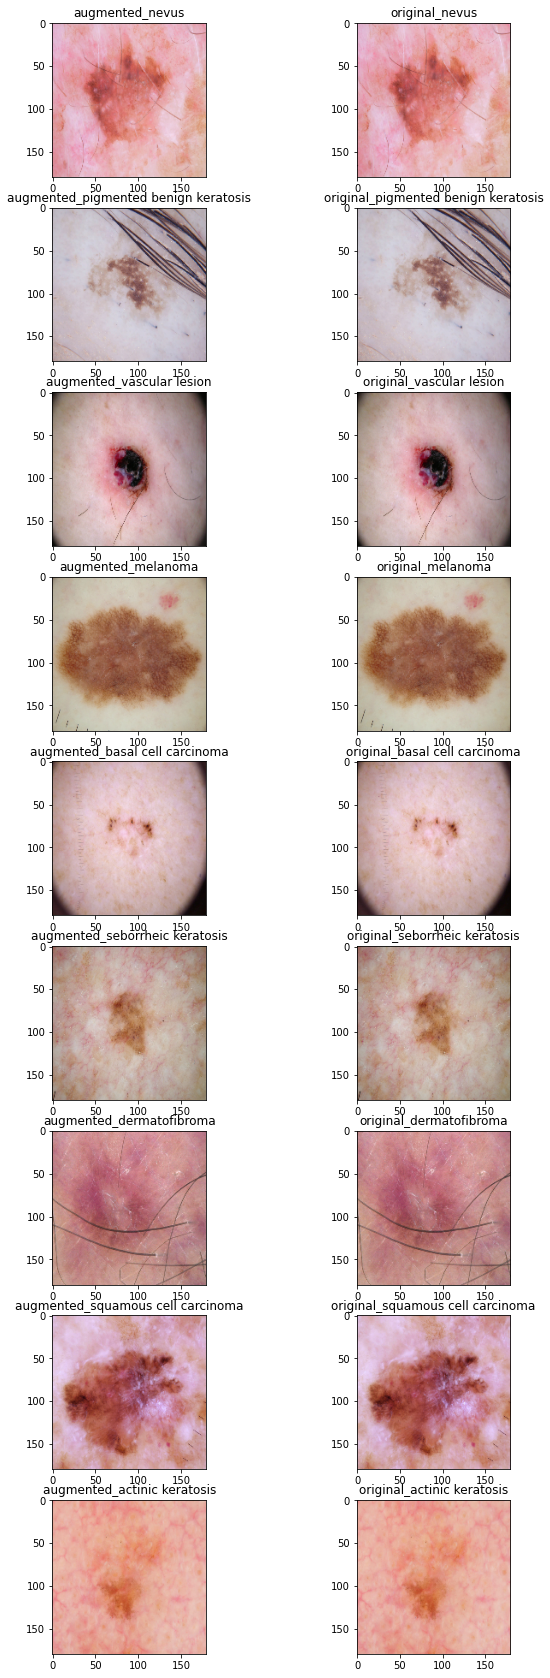

In [25]:
# Todo, visualize how your augmentation strategy works for one instance of training image.
plot_idx=0
visited={}
visited_all=False
plt.figure(figsize=(10,30))
for images, labels in train_ds.take(50):
  if not visited_all:
    for i in range(9):
      if len(visited.keys())==9:
        visited_all=True
        break
      if class_names[labels[i]] in visited.keys():
        continue
      else:
        plt.subplot(9,2,plot_idx+1)
        x=data_aug(images)
        plt.imshow(x[i].numpy().astype("uint8"));
        # plt.imshow(images[i].numpy().astype("uint8"));
        plt.title("augmented_"+class_names[labels[i]])
        plot_idx+=1
        plt.subplot(9,2,plot_idx+1)
        plt.imshow(images[i].numpy().astype("uint8"))
        plt.title("original_"+class_names[labels[i]])
        visited[class_names[labels[i]]]="Y"
        plot_idx+=1
        
  else:
    break

Treat overfitting with Drop out layer:
### Create the model, compile and train the model


In [26]:
## You can use Dropout layer if there is an evidence of overfitting in your findings

input_shape = (180,180,3)
num_classes = 9

model = Sequential([ data_aug,
   layers.experimental.preprocessing.Rescaling(1./255, input_shape=(img_height, img_width,3))
])

model.add(Conv2D(32, kernel_size=(3, 3), activation='relu', padding='same', input_shape = input_shape))
model.add(Conv2D(32, kernel_size=(3, 3), activation='relu', padding='same'))
model.add(MaxPooling2D(pool_size=(2, 2)))

model.add(Conv2D(64, kernel_size=(3, 3), activation='relu', padding='same'))
model.add(MaxPooling2D(pool_size=(2, 2)))

model.add(Conv2D(128, kernel_size=(3, 3), activation='relu', padding='same'))
model.add(MaxPooling2D(pool_size=(2, 2)))

model.add(Flatten())
model.add(Dense(512, activation='relu')) 
model.add(Dropout(0.5))
model.add(Dense(num_classes, activation='softmax'))



### Compiling the model

In [27]:

model.compile(optimizer='adam',
          loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
          metrics=['accuracy']
)

In [28]:
model.summary()

Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 sequential_1 (Sequential)   (None, 180, 180, 3)       0         
                                                                 
 rescaling_2 (Rescaling)     (None, 180, 180, 3)       0         
                                                                 
 conv2d_4 (Conv2D)           (None, 180, 180, 32)      896       
                                                                 
 conv2d_5 (Conv2D)           (None, 180, 180, 32)      9248      
                                                                 
 max_pooling2d_3 (MaxPooling  (None, 90, 90, 32)       0         
 2D)                                                             
                                                                 
 conv2d_6 (Conv2D)           (None, 90, 90, 64)        18496     
                                                      

### Training the model

In [29]:
## Your code goes here, note: train your model for 20 epochs
epochs = 20
history = model.fit(
  train_ds,
  validation_data = val_ds,
  epochs=epochs
)

Epoch 1/20
56/56 [==============================] - 6s 95ms/step - loss: 2.1136 - accuracy: 0.2098 - val_loss: 1.8859 - val_accuracy: 0.3311
Epoch 2/20
56/56 [==============================] - 5s 93ms/step - loss: 1.8174 - accuracy: 0.3605 - val_loss: 1.6424 - val_accuracy: 0.4049
Epoch 3/20
56/56 [==============================] - 5s 92ms/step - loss: 1.7049 - accuracy: 0.3934 - val_loss: 1.6917 - val_accuracy: 0.4273
Epoch 4/20
56/56 [==============================] - 5s 92ms/step - loss: 1.6734 - accuracy: 0.3979 - val_loss: 1.6242 - val_accuracy: 0.4519
Epoch 5/20
56/56 [==============================] - 5s 92ms/step - loss: 1.6290 - accuracy: 0.3979 - val_loss: 1.5459 - val_accuracy: 0.4452
Epoch 6/20
56/56 [==============================] - 5s 92ms/step - loss: 1.5725 - accuracy: 0.4286 - val_loss: 1.5390 - val_accuracy: 0.4430
Epoch 7/20
56/56 [==============================] - 5s 93ms/step - loss: 1.5106 - accuracy: 0.4749 - val_loss: 1.4974 - val_accuracy: 0.5011
Epoch 8/20
56

In [30]:
loss, accuracy = model.evaluate(train_ds, verbose=1,)
loss_v, accuracy_v = model.evaluate(val_ds, verbose=1)

print("Accuracy: ", accuracy)
print("Validation Accuracy: ",accuracy_v)
print("Loss: ",loss)
print("Validation Loss", loss_v)

14/14 [==============================] - 0s 26ms/step - loss: 1.3117 - accuracy: 0.5324
Accuracy:  0.5541294813156128
Validation Accuracy:  0.5324384570121765
Loss:  1.2225650548934937
Validation Loss 1.3116830587387085


### Visualizing the results

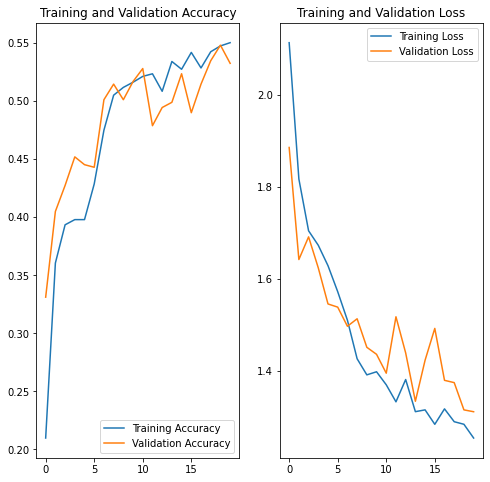

In [31]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

loss = history.history['loss']
val_loss = history.history['val_loss']

epochs_range = range(epochs)

plt.figure(figsize=(8, 8))
plt.subplot(1, 2, 1)
plt.plot(epochs_range, acc, label='Training Accuracy')
plt.plot(epochs_range, val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(1, 2, 2)
plt.plot(epochs_range, loss, label='Training Loss')
plt.plot(epochs_range, val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.show()

#### Todo: Write your findings after the model fit, see if there is an evidence of model overfit or underfit. Do you think there is some improvement now as compared to the previous model run?

### Findings from the Model-2 here:
1. **Underfitted Model**:The data augmentation strategy proved helpful in reducing overfitting but now test accuracy has dropped to 55.41% and 53.2% as validation accuracy. The model appear to be underfitted and would require further processing and hyper parameter  tuning.

#### **Todo:** Find the distribution of classes in the training dataset.
#### **Context:** Many times real life datasets can have class imbalance, one class can have proportionately higher number of samples compared to the others. Class imbalance can have a detrimental effect on the final model quality. Hence as a sanity check it becomes important to check what is the distribution of classes in the data.

<BarContainer object of 9 artists>

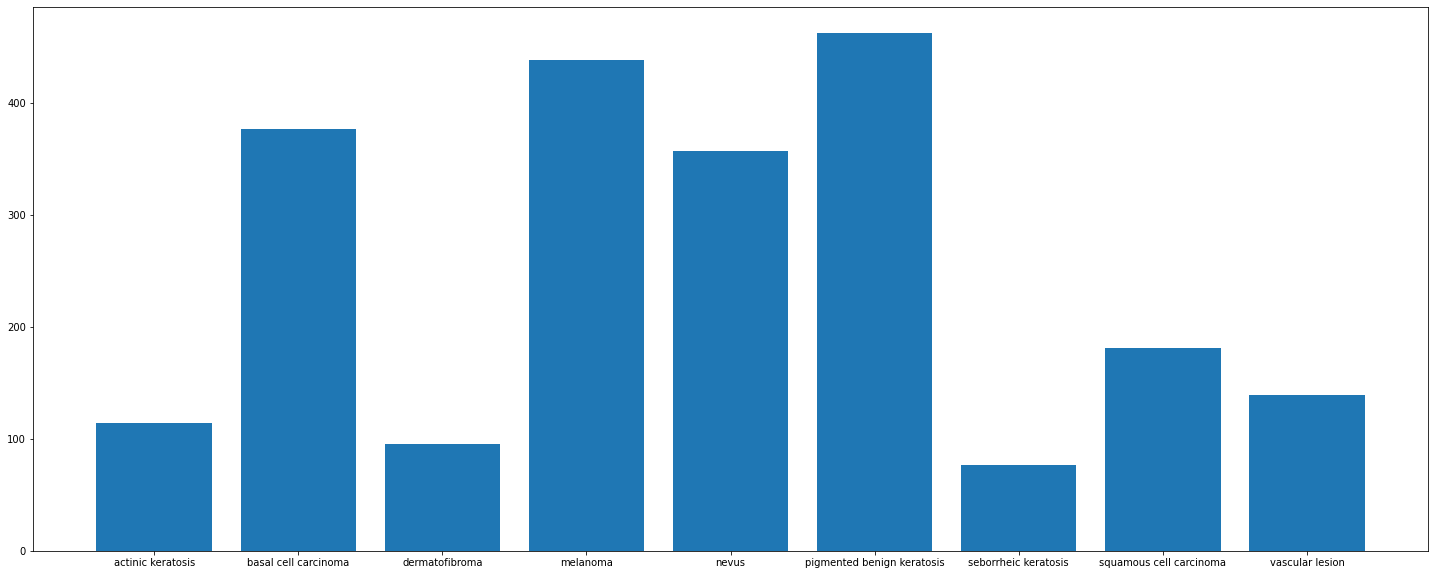

In [32]:
## Your code goes here.
count=[]
for i in class_names:
    count.append(len(list(data_dir_train.glob(i+'/*.jpg'))))
plt.figure(figsize=(25,10))
plt.bar(class_names,count)

#### **Todo:** Write your findings here: 
#### - Which class has the least number of samples?
*   'seborrheic keratosis'class has least no. of samples.

#### - Which classes dominate the data in terms proportionate number of samples?
*   Class 'pigmented benign keratosis' dominates the data.




#### **Todo:** Rectify the class imbalance
#### **Context:** You can use a python package known as `Augmentor` (https://augmentor.readthedocs.io/en/master/) to add more samples across all classes so that none of the classes have very few samples.

In [33]:
!pip install Augmentor

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


To use `Augmentor`, the following general procedure is followed:

1. Instantiate a `Pipeline` object pointing to a directory containing your initial image data set.<br>
2. Define a number of operations to perform on this data set using your `Pipeline` object.<br>
3. Execute these operations by calling the `Pipeline’s` `sample()` method.


In [34]:
path_to_training_dataset= root_path +"/Train/"
import Augmentor
for i in class_names:
    p = Augmentor.Pipeline(path_to_training_dataset + i)
    p.rotate(probability=0.7, max_left_rotation=10, max_right_rotation=10)
    p.sample(500) ## We are adding 500 samples per class to make sure that none of the classes are sparse.

Initialised with 114 image(s) found.
Output directory set to /content/gdrive/My Drive/Melanoma Detection-CNN/Train/actinic keratosis/output.

Processing <PIL.Image.Image image mode=RGB size=600x450 at 0x7F954F8A3C90>: 100%|██████████| 500/500 [00:19<00:00, 25.11 Samples/s]


Initialised with 376 image(s) found.
Output directory set to /content/gdrive/My Drive/Melanoma Detection-CNN/Train/basal cell carcinoma/output.

Processing <PIL.Image.Image image mode=RGB size=600x450 at 0x7F964F828FD0>: 100%|██████████| 500/500 [00:21<00:00, 23.59 Samples/s]


Initialised with 95 image(s) found.
Output directory set to /content/gdrive/My Drive/Melanoma Detection-CNN/Train/dermatofibroma/output.

Processing <PIL.Image.Image image mode=RGB size=600x450 at 0x7F954D0CA610>: 100%|██████████| 500/500 [00:21<00:00, 23.50 Samples/s]


Initialised with 438 image(s) found.
Output directory set to /content/gdrive/My Drive/Melanoma Detection-CNN/Train/melanoma/output.

Processing <PIL.JpegImagePlugin.JpegImageFile image mode=RGB size=767x576 at 0x7F954D0E4E50>: 100%|██████████| 500/500 [01:30<00:00,  5.53 Samples/s]


Initialised with 357 image(s) found.
Output directory set to /content/gdrive/My Drive/Melanoma Detection-CNN/Train/nevus/output.

Processing <PIL.Image.Image image mode=RGB size=1504x1129 at 0x7F954F928ED0>: 100%|██████████| 500/500 [01:15<00:00,  6.65 Samples/s]


Initialised with 462 image(s) found.
Output directory set to /content/gdrive/My Drive/Melanoma Detection-CNN/Train/pigmented benign keratosis/output.

Processing <PIL.Image.Image image mode=RGB size=600x450 at 0x7F964F8244D0>: 100%|██████████| 500/500 [00:17<00:00, 28.06 Samples/s]


Initialised with 77 image(s) found.
Output directory set to /content/gdrive/My Drive/Melanoma Detection-CNN/Train/seborrheic keratosis/output.

Processing <PIL.JpegImagePlugin.JpegImageFile image mode=RGB size=1024x768 at 0x7F954D133B90>: 100%|██████████| 500/500 [00:40<00:00, 12.26 Samples/s]


Initialised with 181 image(s) found.
Output directory set to /content/gdrive/My Drive/Melanoma Detection-CNN/Train/squamous cell carcinoma/output.

Processing <PIL.Image.Image image mode=RGB size=600x450 at 0x7F9550343BD0>: 100%|██████████| 500/500 [00:18<00:00, 27.69 Samples/s]


Initialised with 139 image(s) found.
Output directory set to /content/gdrive/My Drive/Melanoma Detection-CNN/Train/vascular lesion/output.

Processing <PIL.Image.Image image mode=RGB size=600x450 at 0x7F95CC81DF90>: 100%|██████████| 500/500 [00:18<00:00, 26.97 Samples/s]


Augmentor has stored the augmented images in the output sub-directory of each of the sub-directories of skin cancer types.. Lets take a look at total count of augmented images.

In [35]:
image_count_train = len(list(data_dir_train.glob('*/output/*.jpg')))
print(image_count_train)

4500


### Lets see the distribution of augmented data after adding new images to the original training data.

In [36]:
from glob import glob

path_list = [x for x in glob(os.path.join(data_dir_train, '*','output', '*.jpg'))]
path_list

['/content/gdrive/My Drive/Melanoma Detection-CNN/Train/melanoma/output/melanoma_original_ISIC_0000158.jpg_94ffbcff-56eb-4cb0-9b26-67dcfd551d86.jpg',
 '/content/gdrive/My Drive/Melanoma Detection-CNN/Train/melanoma/output/melanoma_original_ISIC_0010379.jpg_22046771-607d-4bbb-97fc-9d846273ad84.jpg',
 '/content/gdrive/My Drive/Melanoma Detection-CNN/Train/melanoma/output/melanoma_original_ISIC_0010503.jpg_00b3eb10-932e-4b90-9185-54e3eed71475.jpg',
 '/content/gdrive/My Drive/Melanoma Detection-CNN/Train/melanoma/output/melanoma_original_ISIC_0010900.jpg_a984e19e-a758-4be1-8ea6-28331a8c95ce.jpg',
 '/content/gdrive/My Drive/Melanoma Detection-CNN/Train/melanoma/output/melanoma_original_ISIC_0011094.jpg_ff0e5e83-13e6-4d17-822d-7c828c45a73c.jpg',
 '/content/gdrive/My Drive/Melanoma Detection-CNN/Train/melanoma/output/melanoma_original_ISIC_0000170.jpg_f2624830-c4ba-4292-b101-d455b36161b2.jpg',
 '/content/gdrive/My Drive/Melanoma Detection-CNN/Train/melanoma/output/melanoma_original_ISIC_00102

In [37]:
lesion_list_new = [os.path.basename(os.path.dirname(os.path.dirname(y))) for y in glob(os.path.join(data_dir_train, '*','output', '*.jpg'))]
lesion_list_new

['melanoma',
 'melanoma',
 'melanoma',
 'melanoma',
 'melanoma',
 'melanoma',
 'melanoma',
 'melanoma',
 'melanoma',
 'melanoma',
 'melanoma',
 'melanoma',
 'melanoma',
 'melanoma',
 'melanoma',
 'melanoma',
 'melanoma',
 'melanoma',
 'melanoma',
 'melanoma',
 'melanoma',
 'melanoma',
 'melanoma',
 'melanoma',
 'melanoma',
 'melanoma',
 'melanoma',
 'melanoma',
 'melanoma',
 'melanoma',
 'melanoma',
 'melanoma',
 'melanoma',
 'melanoma',
 'melanoma',
 'melanoma',
 'melanoma',
 'melanoma',
 'melanoma',
 'melanoma',
 'melanoma',
 'melanoma',
 'melanoma',
 'melanoma',
 'melanoma',
 'melanoma',
 'melanoma',
 'melanoma',
 'melanoma',
 'melanoma',
 'melanoma',
 'melanoma',
 'melanoma',
 'melanoma',
 'melanoma',
 'melanoma',
 'melanoma',
 'melanoma',
 'melanoma',
 'melanoma',
 'melanoma',
 'melanoma',
 'melanoma',
 'melanoma',
 'melanoma',
 'melanoma',
 'melanoma',
 'melanoma',
 'melanoma',
 'melanoma',
 'melanoma',
 'melanoma',
 'melanoma',
 'melanoma',
 'melanoma',
 'melanoma',
 'melanoma',

In [38]:
dataframe_dict_new = dict(zip(path_list, lesion_list_new))

In [39]:
df2 = pd.DataFrame(list(dataframe_dict_new.items()),columns = ['Path','Label'])
new_df = df2

In [40]:
new_df['Label'].value_counts()

melanoma                      500
pigmented benign keratosis    500
nevus                         500
basal cell carcinoma          500
actinic keratosis             500
squamous cell carcinoma       500
vascular lesion               500
seborrheic keratosis          500
dermatofibroma                500
Name: Label, dtype: int64

So, now we have added 500 images to all the classes to maintain some class balance. We can add more images as we want to improve training process.

#### **Todo**: Train the model on the data created using Augmentor

In [41]:
batch_size = 32
img_height = 180
img_width = 180

#### **Todo:** Create a training dataset

In [42]:
data_dir_train= root_path + "/Train/"
train_ds = tf.keras.preprocessing.image_dataset_from_directory(
  data_dir_train,
  seed=123,
  validation_split = 0.2,
  subset = 'training', 
  image_size=(img_height, img_width),
  batch_size=batch_size)

Found 6739 files belonging to 9 classes.
Using 5392 files for training.


#### **Todo:** Create a validation dataset

In [43]:
val_ds = tf.keras.preprocessing.image_dataset_from_directory(
  data_dir_train,
  seed=123,
  validation_split = 0.2,
  subset = 'validation',
  image_size=(img_height, img_width),
  batch_size=batch_size)

Found 6739 files belonging to 9 classes.
Using 1347 files for validation.


#### **Todo:** Create your model (make sure to include normalization)

In [44]:

# Rescale the image
preprocessing_layers = [
    tf.keras.layers.experimental.preprocessing.Rescaling(1./255, input_shape=(180, 180, 3))
]

input_shape = (180,180,3)
num_classes = 9

model = Sequential()
model.add(tf.keras.layers.experimental.preprocessing.Rescaling(1./255, input_shape = input_shape))
model.add(Conv2D(32, kernel_size=(3, 3), activation='relu', padding='same', input_shape = input_shape))
model.add(Conv2D(32, kernel_size=(3, 3), activation='relu', padding='same'))
model.add(MaxPooling2D(pool_size=(2, 2)))

model.add(Conv2D(64, kernel_size=(3, 3), activation='relu', padding='same'))
model.add(MaxPooling2D(pool_size=(2, 2)))

model.add(Conv2D(128, kernel_size=(3, 3), activation='relu', padding='same'))
model.add(MaxPooling2D(pool_size=(2, 2)))

model.add(Flatten())
model.add(Dense(512, activation='relu')) 
model.add(Dropout(0.5))
model.add(Dense(num_classes, activation='softmax'))

#### **Todo:** Compile your model (Choose optimizer and loss function appropriately)

In [45]:
## your code goes here
model.compile(optimizer='adam',
          loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
          metrics=['accuracy']
)

In [46]:
model.summary()


Model: "sequential_3"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 rescaling_4 (Rescaling)     (None, 180, 180, 3)       0         
                                                                 
 conv2d_8 (Conv2D)           (None, 180, 180, 32)      896       
                                                                 
 conv2d_9 (Conv2D)           (None, 180, 180, 32)      9248      
                                                                 
 max_pooling2d_6 (MaxPooling  (None, 90, 90, 32)       0         
 2D)                                                             
                                                                 
 conv2d_10 (Conv2D)          (None, 90, 90, 64)        18496     
                                                                 
 max_pooling2d_7 (MaxPooling  (None, 45, 45, 64)       0         
 2D)                                                  

#### **Todo:**  Train your model

In [47]:
epochs = 30 ## orig it was 30
## Your code goes here, use 50 epochs.
history = model.fit(
  train_ds,
  validation_data = val_ds,
  epochs=epochs
)

Epoch 1/30
169/169 [==============================] - 34s 194ms/step - loss: 1.8889 - accuracy: 0.2815 - val_loss: 1.5268 - val_accuracy: 0.4232
Epoch 2/30
169/169 [==============================] - 32s 185ms/step - loss: 1.5456 - accuracy: 0.3947 - val_loss: 1.4282 - val_accuracy: 0.4618
Epoch 3/30
169/169 [==============================] - 35s 200ms/step - loss: 1.4287 - accuracy: 0.4559 - val_loss: 1.3650 - val_accuracy: 0.5078
Epoch 4/30
169/169 [==============================] - 33s 188ms/step - loss: 1.3093 - accuracy: 0.5019 - val_loss: 1.2256 - val_accuracy: 0.5605
Epoch 5/30
169/169 [==============================] - 33s 187ms/step - loss: 1.1557 - accuracy: 0.5623 - val_loss: 1.1786 - val_accuracy: 0.5887
Epoch 6/30
169/169 [==============================] - 32s 186ms/step - loss: 0.9786 - accuracy: 0.6398 - val_loss: 1.0156 - val_accuracy: 0.6503
Epoch 7/30
169/169 [==============================] - 37s 215ms/step - loss: 0.8546 - accuracy: 0.6871 - val_loss: 0.8246 - val_ac

In [48]:
loss, accuracy = model.evaluate(train_ds, verbose=1,)
loss_v, accuracy_v = model.evaluate(val_ds, verbose=1)

print("Accuracy: ", accuracy)
print("Validation Accuracy: ",accuracy_v)
print("Loss: ",loss)
print("Validation Loss", loss_v)


43/43 [==============================] - 6s 123ms/step - loss: 0.9149 - accuracy: 0.8389
Accuracy:  0.9686572551727295
Validation Accuracy:  0.8389012813568115
Loss:  0.07860954850912094
Validation Loss 0.9149214625358582


#### **Todo:**  Visualize the model results

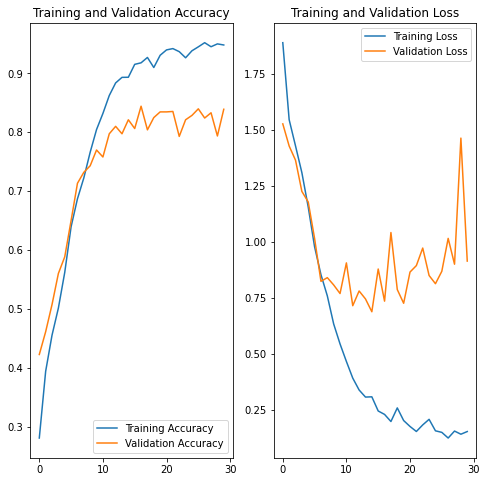

In [49]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

loss = history.history['loss']
val_loss = history.history['val_loss']

epochs_range = range(epochs)

plt.figure(figsize=(8, 8))
plt.subplot(1, 2, 1)
plt.plot(epochs_range, acc, label='Training Accuracy')
plt.plot(epochs_range, val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(1, 2, 2)
plt.plot(epochs_range, loss, label='Training Loss')
plt.plot(epochs_range, val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.show()

#### **Todo:**  Analyze your results here. Did you get rid of underfitting/overfitting? Did class rebalance help?



### Findings from the Model-3 here:


*   Treating class imbalance certainly by addig sample images has certainly improved the model accuracy significantly and get rid  of  underfittig/overfitting. The Training accuracy has shot upto  96.86% while test accuracy has also shot upto 83.89% 



**Overall Summary**

1. With the  first model, we got an overfitted model with training accuracy 82.58% while validation  accuracy at 46.75% only.

2. For the Second model, we tried data augmentation and using ImageDataGenerator we observed some  dicrease in overall accuracy for both train and validation  dataset.[Training Accuracy=55.41% and Validation Accuracy=53.24%]

3. We treated class imbalances in the training dataset and with that we were able to get rid of  both Overfitting and Underfitting of the model  and the  overall efficiencies of the model surged to  96.86% for training and 83.89% for validation. 